<a href="https://colab.research.google.com/github/kamillyruseler/Sales-Leads-MLOps/blob/main/Sales_Leads_an_MLOps_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales Leads - an MLOps approach

*The problem:*

many companies benefit from sales lead systems to capture customers who are likely to close a deal. In this sense, a machine learning lifecycle is ideal for solving the problem, which begins with preparing lead data, goes through prediction, and ends with validation, testing, and monitoring of the model. In our case, what we want to predict is the **target** variable (binary target variable indicating whether the call resulted in a sale ( 1 ) or not ( 0 ).)
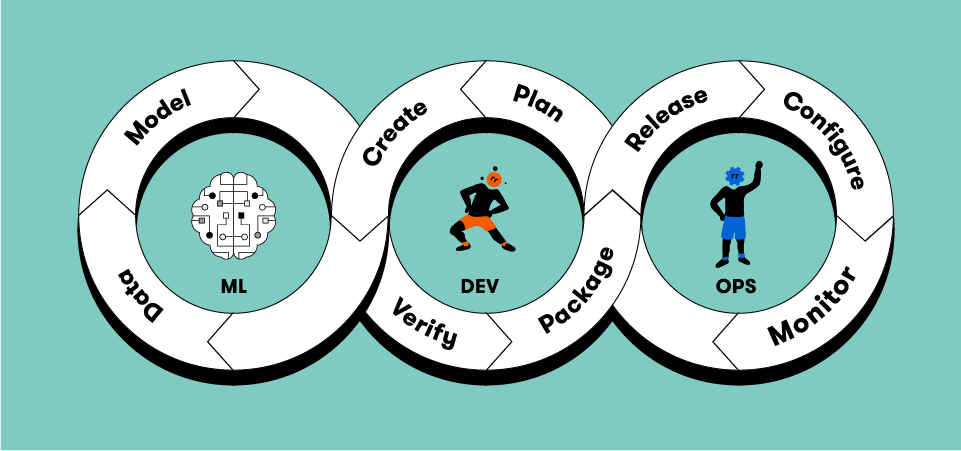

Data Description
The dataset consists of three main categories of information:

* Call Data: Includes details specific to each call, such as duration, time of day, and labels indicating sales outcomes (confirmed or not). **The dataset have an imbalance between sales and non-sales calls.**
* Geo Data: Contains location-based features associated with the calls, potentially including zip codes, regions, or geographic coordinates.
* Census Data: Provides demographic and socioeconomic information for the call locations, such as average income, population density, and other relevant attributes.


Our final workfload was built in Prefect:
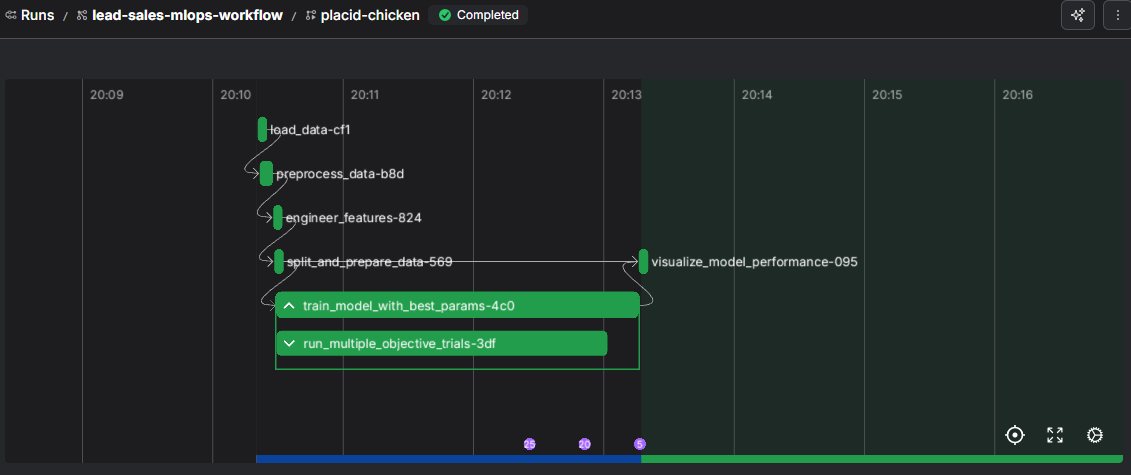

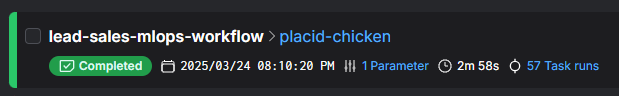

First, let's install Mlflow, Prefect and Optuna:


**MLflow**: is an open-source platform for managing the end-to-end machine learning lifecycle. It provides key features:

*   Tracking experiments and recording parameters, metrics, and artifacts
*   Packaging ML code in a reusable and reproducible format
* Sharing and deploying machine learning models
Managing a central model registry

**Prefect**: is a workflow management system designed to make building, running, and monitoring data pipelines easier:

* Orchestrates complex data workflows and machine learning pipelines
* Provides robust error handling and retry mechanisms
* Supports distributed computing and cloud deployments
* Offers real-time monitoring and logging of data flows

**Optuna**: is a hyperparameter optimization framework that automates the process of finding the best model configuration:

* Uses state-of-the-art optimization algorithms like Tree-structured Parzen Estimator (TPE)
* Supports various machine learning frameworks (scikit-learn, TensorFlow, PyTorch, etc.)
* Provides visualization tools for study analysis
* Allows flexible and intuitive hyperparameter definition

In [ ]:
!pip install mlflow prefect optuna

In [ ]:
!pip install -U prefect

Replace with your Prefect key:

In [ ]:
!prefect cloud login -k your_key

It looks like you're already authenticated on this profile.
? Would you like to reauthenticate? [y/N]: y
Authenticated with Prefect Cloud! Using workspace 'kamilly/default'.


Importing the libraries:

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import mlflow
import mlflow.sklearn

from prefect import flow, task
from prefect.task_runners import ConcurrentTaskRunner

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

import lightgbm as lgb
import optuna
import warnings
warnings.filterwarnings('ignore')

Loading the data (which was stored in Google Colab):

In [ ]:
@task
def load_data(file_path):
    """
    Load the dataset from the specified file path

    Args:
        file_path (str): Path to the CSV file

    Returns:
        pd.DataFrame: Loaded dataset
    """
    print("Loading dataset...")
    df = pd.read_csv(file_path)
    return df

Preprocessing the data:
this was the part that took most of the time. The data was filled with invalid values, such as:


*   Columns filled with: (X)
*   Lines only containing: -


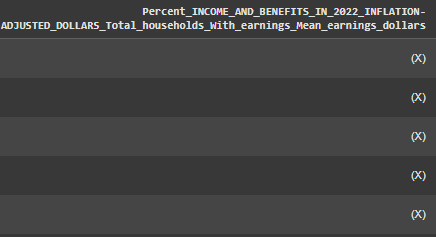

In [ ]:
load_data('/content/ml_task_data.csv').head()

Loading dataset...


23:56:44.888 | INFO    | Task run 'load_data' - Finished in state Completed()

,phone,supplier,call_timestamp,call_day_of_week,call_time_morning_or_afternoon,call_week_of_month,target,zipcode,Estimate_Households_Total,Estimate_Households_Median_income_usd,...,Percent_INCOME_AND_BENEFITS_IN_2022_INFLATION-ADJUSTED_DOLLARS_Total_households_With_earnings,Percent_INCOME_AND_BENEFITS_IN_2022_INFLATION-ADJUSTED_DOLLARS_Total_households_With_earnings_Mean_earnings_dollars,Percent_INCOME_AND_BENEFITS_IN_2022_INFLATION-ADJUSTED_DOLLARS_Total_households_With_retirement_income,Percent_INCOME_AND_BENEFITS_IN_2022_INFLATION-ADJUSTED_DOLLARS_Total_households_With_Food_Stamp_SNAP_benefits_in_the_past_12_months,Percent_INCOME_AND_BENEFITS_IN_2022_INFLATION-ADJUSTED_DOLLARS_Total_households_With_retirement_income_Mean_retirement_income_dollars,Percent_INCOME_AND_BENEFITS_IN_2022_INFLATION-ADJUSTED_DOLLARS_Total_households_With_Social_Security,Percent_INCOME_AND_BENEFITS_IN_2022_INFLATION-ADJUSTED_DOLLARS_Total_households_With_Social_Security_Mean_Social_Security_income_dollars,Percent_INCOME_AND_BENEFITS_IN_2022_INFLATION-ADJUSTED_DOLLARS_Total_households_With_Supplemental_Security_Income,state,countyname
0,3139798283,10882,2024-10-25 14:45:53,6,Afternoon,42,0,48224,13153,41011,...,73.4,(X),23.3,40.2,(X),30.5,(X),13.6,MI,Wayne County
1,3344050897,10751,2024-11-01 12:29:10,6,Afternoon,43,0,36350,2971,52417,...,73.6,(X),19.1,17.1,(X),36.0,(X),9.5,AL,Dale County
2,6013428038,10751,2024-11-08 10:22:02,6,Morning,44,0,39440,7605,38400,...,66.2,(X),22.6,22.0,(X),35.0,(X),9.1,MS,Jones County
3,3183310349,10902,2024-12-03 16:25:04,3,Afternoon,48,0,71202,8875,27627,...,64.8,(X),14.8,41.1,(X),33.4,(X),15.4,LA,Ouachita Parish
4,9563552305,10908,2025-01-24 15:24:37,6,Afternoon,3,0,78537,13828,35214,...,75.4,(X),13.3,42.4,(X),29.6,(X),10.0,TX,Hidalgo County


In [40]:

@task
def preprocess_data(df):
    """
    Preprocess the dataset by cleaning and handling missing values

    Args:
        df (pd.DataFrame): Input dataset

    Returns:
        pd.DataFrame: Preprocessed dataset
    """
    # Remove columns with (X)
    x_columns = [col for col in df.columns if df[col].astype(str).str.contains('\(X\)').any()]
    df = df.drop(columns=x_columns)

    # Define potential null values
    possible_null_values = ["", "NA", "N/A", "-", "null", "NULL", "None", "NaN", "N"]

    # Convert specific values to NaN
    df_cleaned = df.replace(possible_null_values, np.nan)

    # List of invalid values to filter out
    invalid_values = ["-", "N", "NA", "N/A", "null", "NULL", "nan", "NaN", "(X)"]

    # Create a mask to identify valid rows
    valid_rows_mask = pd.Series(True, index=df_cleaned.index)

    # Check for invalid values in each column
    for column in [col for col in df_cleaned.columns if col != 'target']:
        invalid_rows = df_cleaned[column].isin(invalid_values) | df_cleaned[column].isna()
        valid_rows_mask = valid_rows_mask & ~invalid_rows

    # Filter DataFrame to keep only valid rows
    df_cleaned = df_cleaned[valid_rows_mask]

    return df_cleaned

Feature engineering:


Date and time features: Dates and times are often transformed into numerical features, such as day of the week, month, year, hour of the day, etc. This allows models to capture temporal patterns.




This is the feature importance plot:
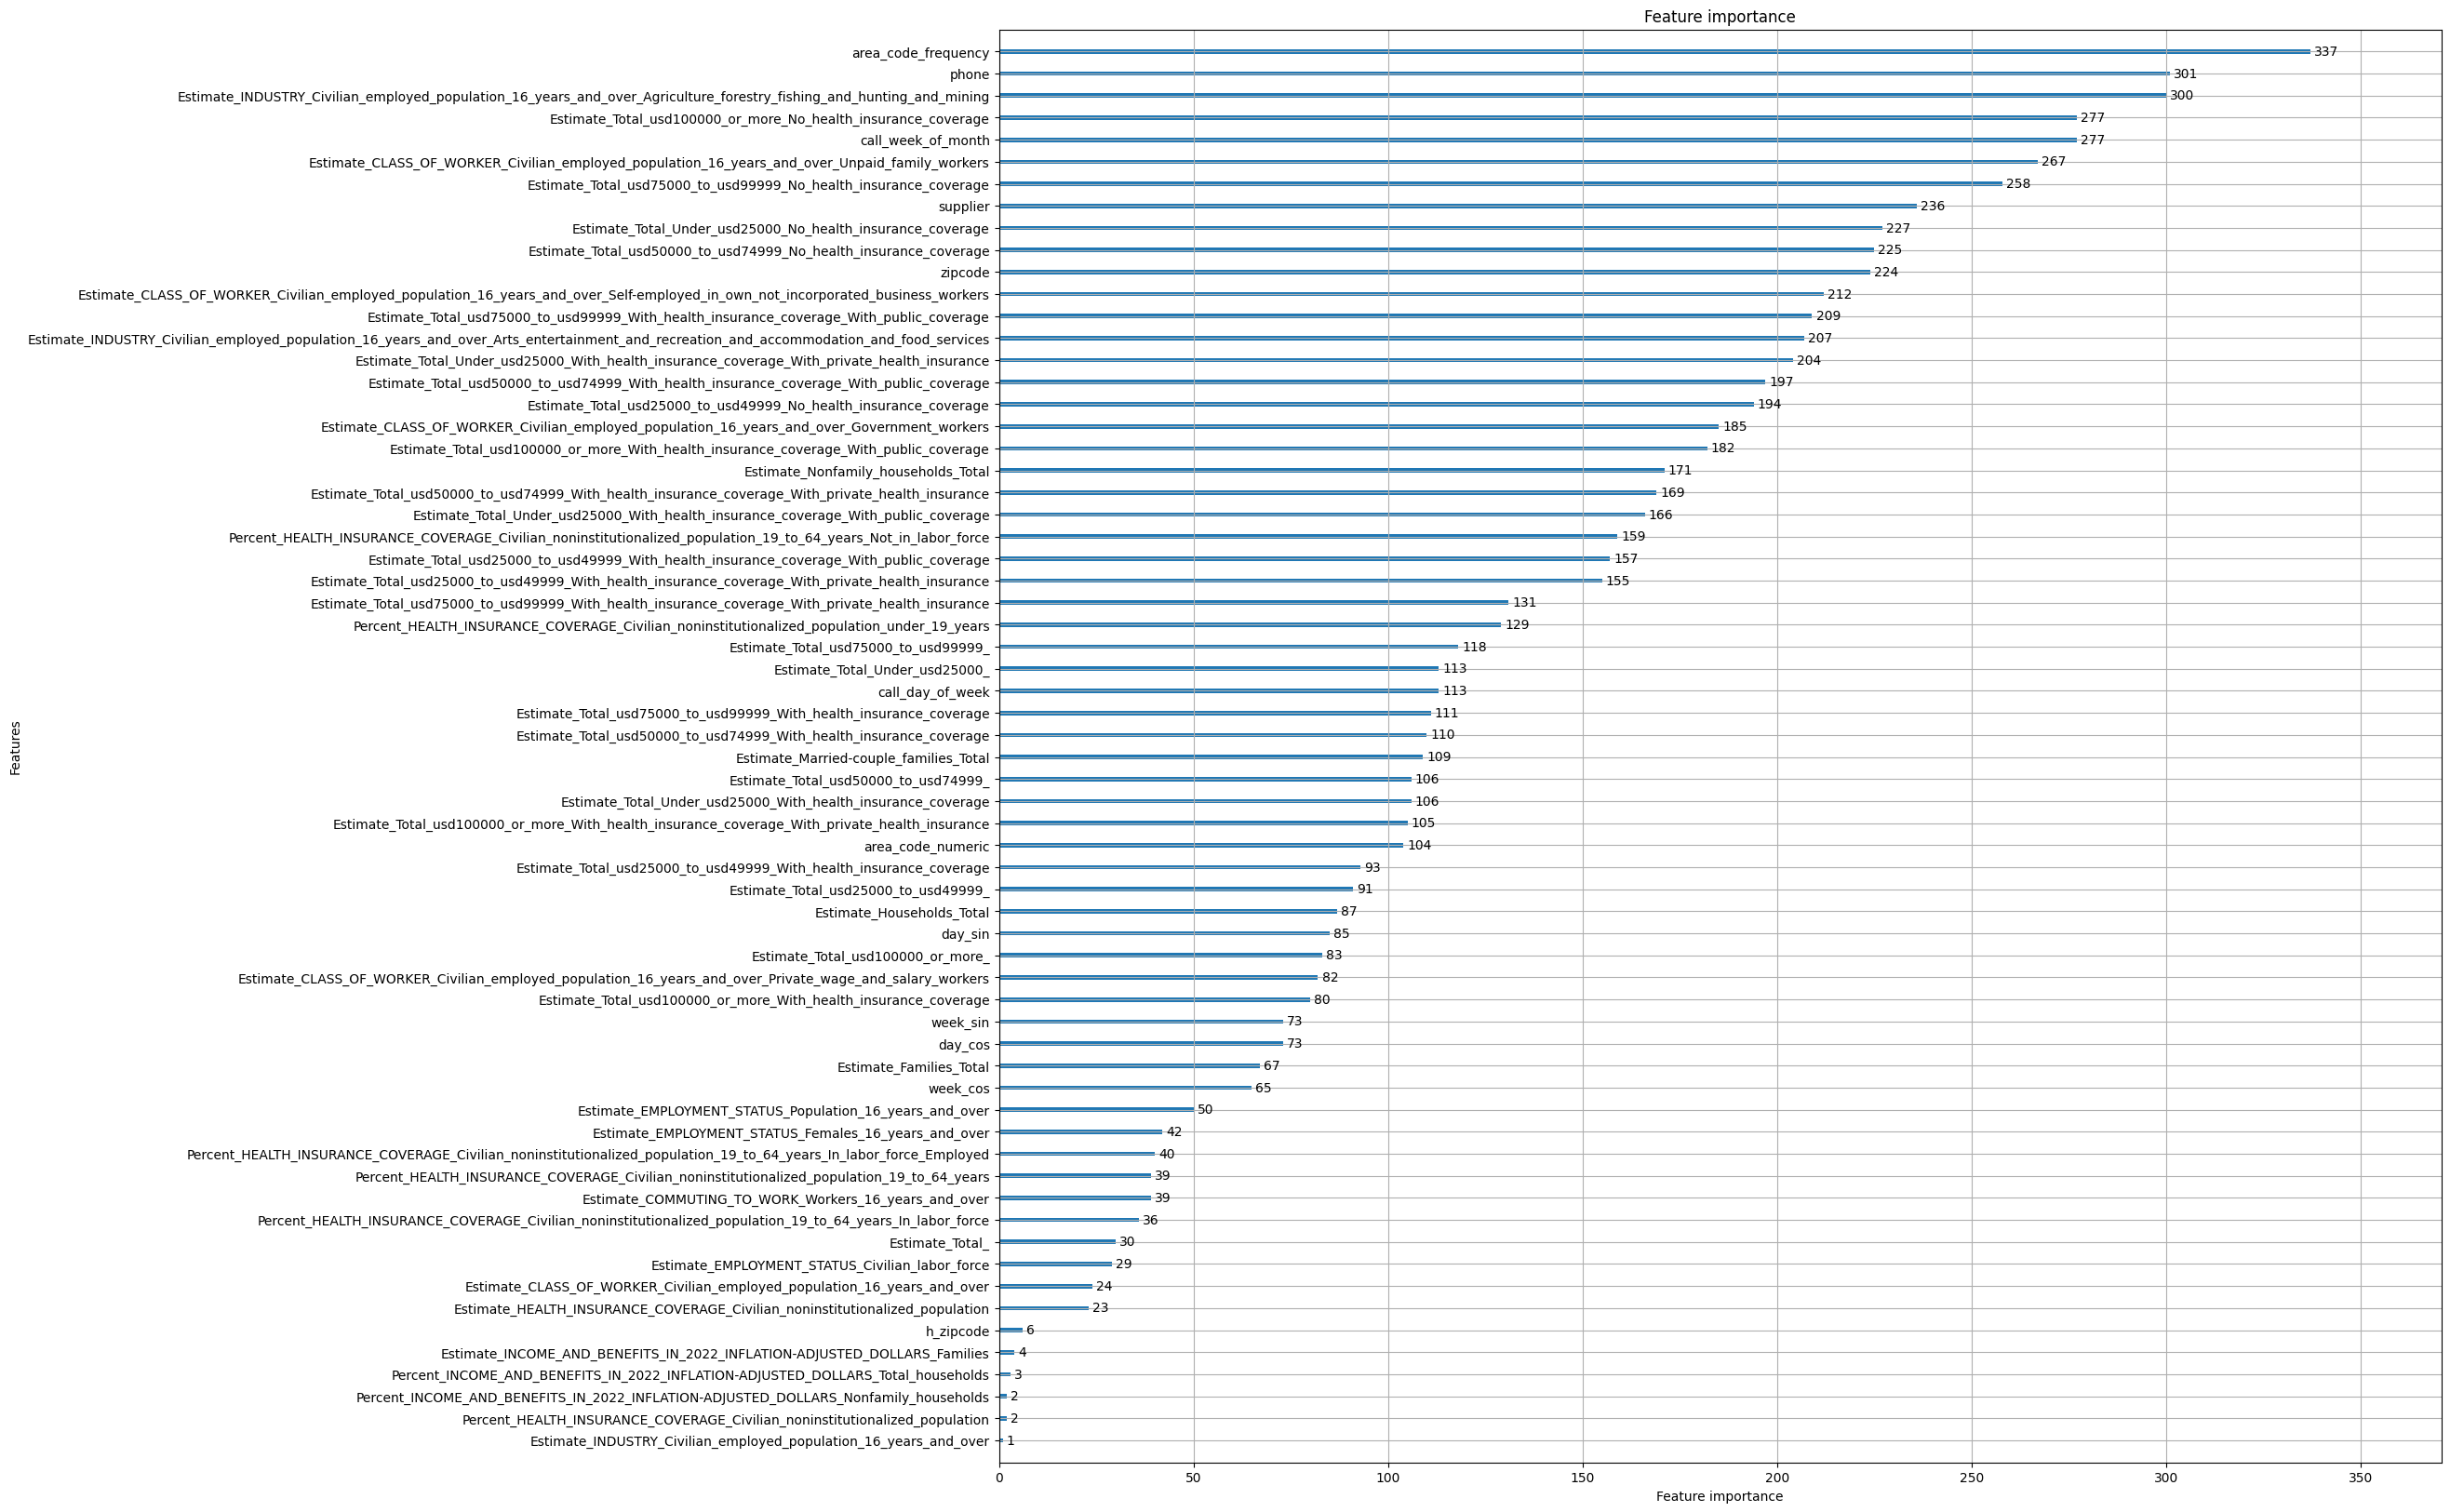

In [ ]:
@task
def engineer_features(df):
    """
    Perform advanced feature engineering on the sales leads dataset

    Args:
        df (pd.DataFrame): Input dataset

    Returns:
        pd.DataFrame: Dataset with engineered features
    """
    # Print target distribution before preprocessing
    print("Target distribution before preprocessing:")
    print(df['target'].value_counts())

    df_processed = df.copy()

    # Impute missing numerical values with median
    num_imputer = SimpleImputer(strategy='median')
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if 'target' in numerical_cols:
        numerical_cols.remove('target')

    if len(numerical_cols) > 0:
        df_processed[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

    # Temporal cyclical features
    if 'call_day_of_week' in df.columns:
        df_processed['day_sin'] = np.sin(2 * np.pi * df['call_day_of_week'] / 7)
        df_processed['day_cos'] = np.cos(2 * np.pi * df['call_day_of_week'] / 7)

    if 'call_week_of_month' in df.columns:
        df_processed['week_sin'] = np.sin(2 * np.pi * df['call_week_of_month'] / 4)
        df_processed['week_cos'] = np.cos(2 * np.pi * df['call_week_of_month'] / 4)

    # Phone-related features
    if 'phone' in df.columns:
        df_processed['area_code'] = df['phone'].astype(str).str[:3]
        area_freq = df_processed['area_code'].value_counts(normalize=True)
        df_processed['area_code_frequency'] = df_processed['area_code'].map(area_freq)
        df_processed['area_code_numeric'] = pd.to_numeric(df_processed['area_code'], errors='coerce')

    # Feature scaling
    new_num_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if 'target' in new_num_cols:
        new_num_cols.remove('target')

    exclude_patterns = ['area_code_', 'income_level', 'zip_region', 'zip_area']
    for pattern in exclude_patterns:
        new_num_cols = [col for col in new_num_cols if pattern not in col]

    scaler = StandardScaler()
    if len(new_num_cols) > 0:
        df_processed[new_num_cols] = scaler.fit_transform(df_processed[new_num_cols])

    print("\nTarget distribution after preprocessing:")
    print(df_processed['target'].value_counts())

    return df_processed

This split_and_prepare_data function as follows is designed to split the dataset into training, validation, and testing sets, and then apply any necessary preprocessing steps to prepare the data for use in machine learning models.


In [ ]:
@task
def split_and_prepare_data(df_engineered):
    """
    Split data into training and testing sets and prepare features

    Args:
        df_engineered (pd.DataFrame): Engineered dataset

    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    X = df_engineered.drop(columns=['target'])
    y = df_engineered['target']

    print("Unique classes in target:", np.unique(y))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("\nClass distribution in target (y_train):")
    print(y_train.value_counts(normalize=True))

    print("\nClass distribution in target (y_test):")
    print(y_test.value_counts(normalize=True))

    # Handle non-numeric columns and timestamp
    non_numeric_cols = X_train.select_dtypes(include=['object', 'datetime']).columns.tolist()
    print("\nNon-numeric columns:", non_numeric_cols)

    if 'timestamp' in non_numeric_cols:
        for dataset in [X_train, X_test]:
            dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])
            dataset['year'] = dataset['timestamp'].dt.year
            dataset['month'] = dataset['timestamp'].dt.month
            dataset['day'] = dataset['timestamp'].dt.day
            dataset['hour'] = dataset['timestamp'].dt.hour
            dataset['minute'] = dataset['timestamp'].dt.minute
            dataset['day_of_week'] = dataset['timestamp'].dt.dayofweek
            dataset.drop(columns=['timestamp'], inplace=True)

    # Remove other non-numeric columns
    for col in non_numeric_cols:
        if col != 'timestamp':
            X_train.drop(columns=[col], inplace=True)
            X_test.drop(columns=[col], inplace=True)

    # Convert to appropriate data types
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)

    return X_train, X_test, y_train, y_test


Now, I aimed to implement hyperparameter optimization using Optuna. Optuna automatically finds the best settings for the model to improve its accuracy.

It does this by searching through different options and choosing the ones that work best

In [ ]:

@task
def objective(trial, X_train, X_test, y_train, y_test):
    """
    Objective function for Optuna hyperparameter optimization

    Args:
        trial (optuna.Trial): Optuna trial object
        X_train, X_test: Training and testing features
        y_train, y_test: Training and testing target

    Returns:
        float: ROC AUC score
    """
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'feature_pre_filter': False,
        'scale_pos_weight': scale_pos_weight,
        'verbose': -1
    }
    num_round = 100

    train_data = lgb.Dataset(X_train, label=y_train)
    bst = lgb.train(params, train_data, num_round)
    y_pred = bst.predict(X_test)

    return roc_auc_score(y_test, y_pred)

Calling Optuna within a Prefect task for organization purposes:

In [ ]:
@task
def run_multiple_objective_trials(X_train, X_test, y_train, y_test, n_trials=50):
    """
    Runs multiple trials of the objective function and returns the results.

    Args:
    X_train, X_test: Training and testing data.
    y_train, y_test: Training and testing labels.
    n_trials: Number of trials to run.

    Returns:
    list: List of results for each trial.
    """
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X_train, X_test, y_train, y_test), n_trials=n_trials)
    return study.best_params

Finally, training the model and saving the artifacts, metrics, tags and model at a local Mlflow.

In [ ]:
@task
def train_model_with_best_params(X_train, X_test, y_train, y_test):
    """
    Train the final model with best hyperparameters

    Args:
        X_train, X_test: Training and testing features
        y_train, y_test: Training and testing target

    Returns:
        tuple: Model, predictions, performance metrics
    """
    mlflow.set_experiment("Lead_Sales")

    with mlflow.start_run():
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
        train_data = lgb.Dataset(X_train, label=y_train)

        best_params = run_multiple_objective_trials(X_train, X_test, y_train, y_test)

        best_params.update({
            'objective': 'binary',
            'metric': 'binary_logloss',
            'boosting_type': 'gbdt',
            'scale_pos_weight': scale_pos_weight,
            'verbose': 0
        })

        bst = lgb.train(best_params, train_data, 100)
        y_pred = bst.predict(X_test)
        y_pred_class = (y_pred > 0.5).astype(int)

        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_pred_class)
        roc_auc = roc_auc_score(y_test, y_pred)
        avg_precision = average_precision_score(y_test, y_pred)
        precision_pos = precision_score(y_test, y_pred_class, pos_label=1)
        recall_pos = recall_score(y_test, y_pred_class, pos_label=1)
        f1_pos = f1_score(y_test, y_pred_class, pos_label=1)

        # Log metrics to MLflow
        mlflow.log_metrics({
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'avg_precision': avg_precision,
            'precision_pos': precision_pos,
            'recall_pos': recall_pos,
            'f1_pos': f1_pos
        })

        # Log model to MLflow
        mlflow.lightgbm.log_model(bst, "lead_sales_model")
        # Feature importance
        lgb.plot_importance(bst, importance_type='split', figsize=(20, 20))
        plt.show()
        plt.savefig("feature_importance.png")

        return bst, y_pred, y_pred_class, {
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'avg_precision': avg_precision,
            'precision_pos': precision_pos,
            'recall_pos': recall_pos,
            'f1_pos': f1_pos
        }

Saving other visualization plots:


In [ ]:
@task
def visualize_model_performance(y_test, y_pred, y_pred_class):
    """
    Generate and save performance visualization plots

    Args:
        y_test: True labels
        y_pred: Predicted probabilities
        y_pred_class: Predicted classes
    """
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.savefig('precision_recall_curve.png')
    plt.close()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.savefig('roc_curve.png')
    plt.close()


Calling all the tasks at the Prefect flow:


19:44:40.929 | INFO    | Flow run 'mottled-meerkat' - Beginning flow run 'mottled-meerkat' for flow 'lead-sales-mlops-workflow'

19:44:40.939 | INFO    | Flow run 'mottled-meerkat' - View at https://app.prefect.cloud/account/fd988c30-aed1-460f-a603-125ad19db08d/workspace/d53ff4b2-1f7c-4e73-9b82-a2cc3e751446/runs/flow-run/17c47c73-7757-47b1-8158-71a6e2ffab4b

Loading dataset...


19:44:42.406 | INFO    | Task run 'load_data-435' - Finished in state Completed()

19:44:47.464 | INFO    | Task run 'preprocess_data-3a5' - Finished in state Completed()

Target distribution before preprocessing:
target
0.0    15016
1.0     2144
Name: count, dtype: int64

Target distribution after preprocessing:
target
0.0    15016
1.0     2144
Name: count, dtype: int64


19:44:48.556 | INFO    | Task run 'engineer_features-ed4' - Finished in state Completed()

Unique classes in target: [0. 1.]

Class distribution in target (y_train):
target
0.0    0.875073
1.0    0.124927
Name: proportion, dtype: float64

Class distribution in target (y_test):
target
0.0    0.875
1.0    0.125
Name: proportion, dtype: float64

Non-numeric columns: ['call_timestamp', 'call_time_morning_or_afternoon', 'Estimate_Households_Median_income_usd', 'Estimate_Households_Mean_income_usd', 'Estimate_Families_Median_income_usd', 'Estimate_Families_Mean_income_usd', 'Estimate_Nonfamily_households_Median_income_usd', 'Estimate_Nonfamily_households_Mean_income_usd', 'Estimate_INCOME_AND_BENEFITS_IN_2022_INFLATION-ADJUSTED_DOLLARS_Per_capita_income_dollars', 'Percent_COMMUTING_TO_WORK_Workers_16_years_and_over_Worked_from_home', 'Percent_HEALTH_INSURANCE_COVERAGE_Civilian_noninstitutionalized_population_19_to_64_years_In_labor_force_Employed_No_health_insurance_coverage', 'Percent_EMPLOYMENT_STATUS_Population_16_years_and_over_Not_in_labor_force', 'Percent_EMPLOYMENT_STATUS_P

19:44:50.346 | INFO    | Task run 'split_and_prepare_data-2db' - Finished in state Completed()

[I 2025-03-27 19:44:51,046] A new study created in memory with name: no-name-9a95c1a6-5ba9-40a4-a6b3-00fd2b6e4873


19:44:58.380 | INFO    | Task run 'objective-3e9' - Finished in state Completed()

[I 2025-03-27 19:44:58,387] Trial 0 finished with value: 0.6407877282003156 and parameters: {'num_leaves': 49, 'learning_rate': 0.22782849851659337, 'feature_fraction': 0.8265752153694779, 'bagging_fraction': 0.8666408888117982, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial 0 with value: 0.6407877282003156.


19:44:59.420 | INFO    | Task run 'objective-de0' - Finished in state Completed()

[I 2025-03-27 19:44:59,427] Trial 1 finished with value: 0.6333154025461718 and parameters: {'num_leaves': 23, 'learning_rate': 0.1938683805919534, 'feature_fraction': 0.968995654931463, 'bagging_fraction': 0.869195081426064, 'bagging_freq': 6, 'min_child_samples': 42}. Best is trial 0 with value: 0.6407877282003156.


19:45:01.165 | INFO    | Task run 'objective-b06' - Finished in state Completed()

[I 2025-03-27 19:45:01,172] Trial 2 finished with value: 0.6601638454785308 and parameters: {'num_leaves': 60, 'learning_rate': 0.019216231824357177, 'feature_fraction': 0.7198612196895153, 'bagging_fraction': 0.9846654331001037, 'bagging_freq': 3, 'min_child_samples': 27}. Best is trial 2 with value: 0.6601638454785308.


19:45:03.145 | INFO    | Task run 'objective-b6c' - Finished in state Completed()

[I 2025-03-27 19:45:03,152] Trial 3 finished with value: 0.6554075295334035 and parameters: {'num_leaves': 70, 'learning_rate': 0.016827968988684234, 'feature_fraction': 0.7790681575736581, 'bagging_fraction': 0.8241896520865813, 'bagging_freq': 7, 'min_child_samples': 14}. Best is trial 2 with value: 0.6601638454785308.


19:45:07.004 | INFO    | Task run 'objective-3a5' - Finished in state Completed()

[I 2025-03-27 19:45:07,012] Trial 4 finished with value: 0.6160172383948608 and parameters: {'num_leaves': 71, 'learning_rate': 0.24707307060978573, 'feature_fraction': 0.8348476931265978, 'bagging_fraction': 0.9301305356835278, 'bagging_freq': 10, 'min_child_samples': 18}. Best is trial 2 with value: 0.6601638454785308.


19:45:08.466 | INFO    | Task run 'objective-851' - Finished in state Completed()

[I 2025-03-27 19:45:08,471] Trial 5 finished with value: 0.647679437889228 and parameters: {'num_leaves': 52, 'learning_rate': 0.053196552642871764, 'feature_fraction': 0.7137292085518923, 'bagging_fraction': 0.9096917226386549, 'bagging_freq': 6, 'min_child_samples': 49}. Best is trial 2 with value: 0.6601638454785308.


19:45:10.561 | INFO    | Task run 'objective-698' - Finished in state Completed()

[I 2025-03-27 19:45:10,565] Trial 6 finished with value: 0.6295021994322694 and parameters: {'num_leaves': 79, 'learning_rate': 0.25471781023303286, 'feature_fraction': 0.8651054361730725, 'bagging_fraction': 0.7296403332669046, 'bagging_freq': 1, 'min_child_samples': 18}. Best is trial 2 with value: 0.6601638454785308.


19:45:11.672 | INFO    | Task run 'objective-b54' - Finished in state Completed()

[I 2025-03-27 19:45:11,676] Trial 7 finished with value: 0.6282179359102436 and parameters: {'num_leaves': 25, 'learning_rate': 0.16345443722376096, 'feature_fraction': 0.9472906026233026, 'bagging_fraction': 0.7806596053254422, 'bagging_freq': 7, 'min_child_samples': 12}. Best is trial 2 with value: 0.6601638454785308.


19:45:13.341 | INFO    | Task run 'objective-c22' - Finished in state Completed()

[I 2025-03-27 19:45:13,346] Trial 8 finished with value: 0.6258093111239964 and parameters: {'num_leaves': 67, 'learning_rate': 0.13561532267993656, 'feature_fraction': 0.7279049338167333, 'bagging_fraction': 0.9422196827276565, 'bagging_freq': 10, 'min_child_samples': 16}. Best is trial 2 with value: 0.6601638454785308.


19:45:14.981 | INFO    | Task run 'objective-c43' - Finished in state Completed()

[I 2025-03-27 19:45:14,989] Trial 9 finished with value: 0.6478843611710744 and parameters: {'num_leaves': 48, 'learning_rate': 0.11131049096455983, 'feature_fraction': 0.9473801386656655, 'bagging_fraction': 0.9811488741368308, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 2 with value: 0.6601638454785308.


19:45:19.004 | INFO    | Task run 'objective-eb6' - Finished in state Completed()

[I 2025-03-27 19:45:19,013] Trial 10 finished with value: 0.6467650453664439 and parameters: {'num_leaves': 85, 'learning_rate': 0.07999935262025344, 'feature_fraction': 0.7705085532743239, 'bagging_fraction': 0.9998165353730863, 'bagging_freq': 3, 'min_child_samples': 31}. Best is trial 2 with value: 0.6601638454785308.


19:45:21.468 | INFO    | Task run 'objective-b8d' - Finished in state Completed()

[I 2025-03-27 19:45:21,473] Trial 11 finished with value: 0.6569560975155381 and parameters: {'num_leaves': 100, 'learning_rate': 0.010300202871758821, 'feature_fraction': 0.77513984368913, 'bagging_fraction': 0.7997819695331531, 'bagging_freq': 4, 'min_child_samples': 28}. Best is trial 2 with value: 0.6601638454785308.


19:45:23.873 | INFO    | Task run 'objective-dd4' - Finished in state Completed()

[I 2025-03-27 19:45:23,880] Trial 12 finished with value: 0.6543285774055004 and parameters: {'num_leaves': 98, 'learning_rate': 0.012171416199604122, 'feature_fraction': 0.7636766801050194, 'bagging_fraction': 0.780949413970186, 'bagging_freq': 4, 'min_child_samples': 28}. Best is trial 2 with value: 0.6601638454785308.


19:45:25.991 | INFO    | Task run 'objective-239' - Finished in state Completed()

[I 2025-03-27 19:45:25,997] Trial 13 finished with value: 0.648247246149344 and parameters: {'num_leaves': 96, 'learning_rate': 0.062292048539466086, 'feature_fraction': 0.7156689285750476, 'bagging_fraction': 0.7009869420827194, 'bagging_freq': 4, 'min_child_samples': 30}. Best is trial 2 with value: 0.6601638454785308.


19:45:27.292 | INFO    | Task run 'objective-787' - Finished in state Completed()

[I 2025-03-27 19:45:27,299] Trial 14 finished with value: 0.6537037166407795 and parameters: {'num_leaves': 35, 'learning_rate': 0.0388266314126767, 'feature_fraction': 0.7962964811077003, 'bagging_fraction': 0.8190876965854755, 'bagging_freq': 4, 'min_child_samples': 26}. Best is trial 2 with value: 0.6601638454785308.


19:45:29.018 | INFO    | Task run 'objective-af2' - Finished in state Completed()

[I 2025-03-27 19:45:29,034] Trial 15 finished with value: 0.6338083051369765 and parameters: {'num_leaves': 61, 'learning_rate': 0.09743595422594796, 'feature_fraction': 0.8863460276241867, 'bagging_fraction': 0.781223783304444, 'bagging_freq': 1, 'min_child_samples': 36}. Best is trial 2 with value: 0.6601638454785308.


19:45:32.840 | INFO    | Task run 'objective-3eb' - Finished in state Completed()

[I 2025-03-27 19:45:32,844] Trial 16 finished with value: 0.6415538618335821 and parameters: {'num_leaves': 84, 'learning_rate': 0.2845708289685053, 'feature_fraction': 0.7451340047171823, 'bagging_fraction': 0.8946823325564895, 'bagging_freq': 3, 'min_child_samples': 24}. Best is trial 2 with value: 0.6601638454785308.


19:45:34.244 | INFO    | Task run 'objective-f11' - Finished in state Completed()

[I 2025-03-27 19:45:34,252] Trial 17 finished with value: 0.6445586270761096 and parameters: {'num_leaves': 38, 'learning_rate': 0.04007734412759423, 'feature_fraction': 0.8083020739995115, 'bagging_fraction': 0.8242078449852379, 'bagging_freq': 8, 'min_child_samples': 36}. Best is trial 2 with value: 0.6601638454785308.


19:45:35.730 | INFO    | Task run 'objective-2c1' - Finished in state Completed()

[I 2025-03-27 19:45:35,738] Trial 18 finished with value: 0.6454485685254917 and parameters: {'num_leaves': 57, 'learning_rate': 0.12151223834753769, 'feature_fraction': 0.7036917137686401, 'bagging_fraction': 0.9690119847152456, 'bagging_freq': 3, 'min_child_samples': 35}. Best is trial 2 with value: 0.6601638454785308.


19:45:37.845 | INFO    | Task run 'objective-698' - Finished in state Completed()

[I 2025-03-27 19:45:37,853] Trial 19 finished with value: 0.6422637191867961 and parameters: {'num_leaves': 89, 'learning_rate': 0.16920814245325247, 'feature_fraction': 0.7512576264300638, 'bagging_fraction': 0.7457107319947326, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 2 with value: 0.6601638454785308.


19:45:39.967 | INFO    | Task run 'objective-368' - Finished in state Completed()

[I 2025-03-27 19:45:39,974] Trial 20 finished with value: 0.6409868297980187 and parameters: {'num_leaves': 77, 'learning_rate': 0.08747486643669176, 'feature_fraction': 0.8937583767035253, 'bagging_fraction': 0.8921063124665293, 'bagging_freq': 2, 'min_child_samples': 41}. Best is trial 2 with value: 0.6601638454785308.


19:45:42.389 | INFO    | Task run 'objective-48b' - Finished in state Completed()

[I 2025-03-27 19:45:42,393] Trial 21 finished with value: 0.6561371806127051 and parameters: {'num_leaves': 67, 'learning_rate': 0.018399836662911267, 'feature_fraction': 0.7870322934851233, 'bagging_fraction': 0.8352936343986422, 'bagging_freq': 8, 'min_child_samples': 10}. Best is trial 2 with value: 0.6601638454785308.


19:45:46.032 | INFO    | Task run 'objective-c53' - Finished in state Completed()

[I 2025-03-27 19:45:46,038] Trial 22 finished with value: 0.6522715823415124 and parameters: {'num_leaves': 62, 'learning_rate': 0.019901211735515616, 'feature_fraction': 0.811648947183928, 'bagging_fraction': 0.8487444896147407, 'bagging_freq': 9, 'min_child_samples': 22}. Best is trial 2 with value: 0.6601638454785308.


19:45:47.435 | INFO    | Task run 'objective-96e' - Finished in state Completed()

[I 2025-03-27 19:45:47,441] Trial 23 finished with value: 0.6458071842687227 and parameters: {'num_leaves': 41, 'learning_rate': 0.06865694066688191, 'feature_fraction': 0.7877312114116629, 'bagging_fraction': 0.8067995989114116, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 2 with value: 0.6601638454785308.


19:45:49.363 | INFO    | Task run 'objective-bf9' - Finished in state Completed()

[I 2025-03-27 19:45:49,371] Trial 24 finished with value: 0.6498839156181813 and parameters: {'num_leaves': 76, 'learning_rate': 0.03686777009109955, 'feature_fraction': 0.7404706534357768, 'bagging_fraction': 0.8412005934390885, 'bagging_freq': 8, 'min_child_samples': 32}. Best is trial 2 with value: 0.6601638454785308.


19:45:51.667 | INFO    | Task run 'objective-b14' - Finished in state Completed()

[I 2025-03-27 19:45:51,675] Trial 25 finished with value: 0.6520053373200227 and parameters: {'num_leaves': 95, 'learning_rate': 0.04854726629866327, 'feature_fraction': 0.7643847773162692, 'bagging_fraction': 0.7513377252235108, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 2 with value: 0.6601638454785308.


19:45:53.489 | INFO    | Task run 'objective-3ad' - Finished in state Completed()

[I 2025-03-27 19:45:53,497] Trial 26 finished with value: 0.6545536825257106 and parameters: {'num_leaves': 55, 'learning_rate': 0.0144442438693601, 'feature_fraction': 0.8563387264936843, 'bagging_fraction': 0.7998361966590128, 'bagging_freq': 5, 'min_child_samples': 27}. Best is trial 2 with value: 0.6601638454785308.


19:45:56.601 | INFO    | Task run 'objective-9e3' - Finished in state Completed()

[I 2025-03-27 19:45:56,607] Trial 27 finished with value: 0.6540786330996121 and parameters: {'num_leaves': 63, 'learning_rate': 0.06793983176087649, 'feature_fraction': 0.73481966694267, 'bagging_fraction': 0.8694823552787252, 'bagging_freq': 7, 'min_child_samples': 40}. Best is trial 2 with value: 0.6601638454785308.


19:45:59.207 | INFO    | Task run 'objective-80e' - Finished in state Completed()

[I 2025-03-27 19:45:59,216] Trial 28 finished with value: 0.6522118130509739 and parameters: {'num_leaves': 45, 'learning_rate': 0.033284033084513755, 'feature_fraction': 0.828079571136362, 'bagging_fraction': 0.9360821079216802, 'bagging_freq': 4, 'min_child_samples': 33}. Best is trial 2 with value: 0.6601638454785308.


19:46:01.297 | INFO    | Task run 'objective-34c' - Finished in state Completed()

[I 2025-03-27 19:46:01,307] Trial 29 finished with value: 0.647526909764672 and parameters: {'num_leaves': 87, 'learning_rate': 0.20775482130265693, 'feature_fraction': 0.8036495531967216, 'bagging_fraction': 0.8571612569766665, 'bagging_freq': 9, 'min_child_samples': 46}. Best is trial 2 with value: 0.6601638454785308.


19:46:03.505 | INFO    | Task run 'objective-54c' - Finished in state Completed()

[I 2025-03-27 19:46:03,513] Trial 30 finished with value: 0.6485942185242886 and parameters: {'num_leaves': 92, 'learning_rate': 0.1392531169970322, 'feature_fraction': 0.7824012302298813, 'bagging_fraction': 0.7621831869620874, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with value: 0.6601638454785308.


19:46:05.646 | INFO    | Task run 'objective-7be' - Finished in state Completed()

[I 2025-03-27 19:46:05,654] Trial 31 finished with value: 0.6582104763922946 and parameters: {'num_leaves': 69, 'learning_rate': 0.013768041618277561, 'feature_fraction': 0.7709464185005076, 'bagging_fraction': 0.8407149502607858, 'bagging_freq': 7, 'min_child_samples': 13}. Best is trial 2 with value: 0.6601638454785308.


19:46:07.778 | INFO    | Task run 'objective-7c7' - Finished in state Completed()

[I 2025-03-27 19:46:07,785] Trial 32 finished with value: 0.6496281496281495 and parameters: {'num_leaves': 67, 'learning_rate': 0.02658322332003483, 'feature_fraction': 0.7549773064867239, 'bagging_fraction': 0.8759348019618979, 'bagging_freq': 8, 'min_child_samples': 10}. Best is trial 2 with value: 0.6601638454785308.


19:46:11.256 | INFO    | Task run 'objective-307' - Finished in state Completed()

[I 2025-03-27 19:46:11,264] Trial 33 finished with value: 0.6510847350008189 and parameters: {'num_leaves': 74, 'learning_rate': 0.05343105189186771, 'feature_fraction': 0.7004251296189449, 'bagging_fraction': 0.8392789299277057, 'bagging_freq': 7, 'min_child_samples': 14}. Best is trial 2 with value: 0.6601638454785308.


19:46:13.130 | INFO    | Task run 'objective-e0a' - Finished in state Completed()

[I 2025-03-27 19:46:13,137] Trial 34 finished with value: 0.6610048847811086 and parameters: {'num_leaves': 67, 'learning_rate': 0.014326624099787534, 'feature_fraction': 0.7261057549124245, 'bagging_fraction': 0.820462202313949, 'bagging_freq': 9, 'min_child_samples': 14}. Best is trial 34 with value: 0.6610048847811086.


19:46:15.126 | INFO    | Task run 'objective-bcb' - Finished in state Completed()

[I 2025-03-27 19:46:15,132] Trial 35 finished with value: 0.6522599389732258 and parameters: {'num_leaves': 81, 'learning_rate': 0.0782899771712471, 'feature_fraction': 0.7265215982360366, 'bagging_fraction': 0.8050185025795625, 'bagging_freq': 9, 'min_child_samples': 20}. Best is trial 34 with value: 0.6610048847811086.


19:46:16.799 | INFO    | Task run 'objective-705' - Finished in state Completed()

[I 2025-03-27 19:46:16,806] Trial 36 finished with value: 0.6600935971565343 and parameters: {'num_leaves': 53, 'learning_rate': 0.010753286433901872, 'feature_fraction': 0.7213909394380063, 'bagging_fraction': 0.9175412100675904, 'bagging_freq': 10, 'min_child_samples': 15}. Best is trial 34 with value: 0.6610048847811086.


19:46:18.364 | INFO    | Task run 'objective-407' - Finished in state Completed()

[I 2025-03-27 19:46:18,372] Trial 37 finished with value: 0.6444984696732949 and parameters: {'num_leaves': 53, 'learning_rate': 0.05110959705943925, 'feature_fraction': 0.7173317615120333, 'bagging_fraction': 0.9160023192394116, 'bagging_freq': 10, 'min_child_samples': 13}. Best is trial 34 with value: 0.6610048847811086.


19:46:22.738 | INFO    | Task run 'objective-145' - Finished in state Completed()

[I 2025-03-27 19:46:22,746] Trial 38 finished with value: 0.6502254544212586 and parameters: {'num_leaves': 72, 'learning_rate': 0.03111705133927837, 'feature_fraction': 0.9910618752000794, 'bagging_fraction': 0.9591340636527325, 'bagging_freq': 10, 'min_child_samples': 16}. Best is trial 34 with value: 0.6610048847811086.


19:46:24.319 | INFO    | Task run 'objective-e11' - Finished in state Completed()

[I 2025-03-27 19:46:24,329] Trial 39 finished with value: 0.6451776661566871 and parameters: {'num_leaves': 57, 'learning_rate': 0.09678765419892463, 'feature_fraction': 0.7289501898289188, 'bagging_fraction': 0.9991149179937217, 'bagging_freq': 9, 'min_child_samples': 19}. Best is trial 34 with value: 0.6610048847811086.


19:46:25.723 | INFO    | Task run 'objective-524' - Finished in state Completed()

[I 2025-03-27 19:46:25,731] Trial 40 finished with value: 0.6428606358676289 and parameters: {'num_leaves': 49, 'learning_rate': 0.18073578064458617, 'feature_fraction': 0.7001707466119167, 'bagging_fraction': 0.9183990892312974, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 34 with value: 0.6610048847811086.


19:46:28.917 | INFO    | Task run 'objective-b81' - Finished in state Completed()

[I 2025-03-27 19:46:28,922] Trial 41 finished with value: 0.6594446734306874 and parameters: {'num_leaves': 64, 'learning_rate': 0.01051872245088031, 'feature_fraction': 0.7481013931808219, 'bagging_fraction': 0.95234432586503, 'bagging_freq': 10, 'min_child_samples': 13}. Best is trial 34 with value: 0.6610048847811086.


19:46:31.341 | INFO    | Task run 'objective-5f9' - Finished in state Completed()

[I 2025-03-27 19:46:31,346] Trial 42 finished with value: 0.6593887852629111 and parameters: {'num_leaves': 66, 'learning_rate': 0.031209658760316283, 'feature_fraction': 0.7495851493111066, 'bagging_fraction': 0.9528134357192966, 'bagging_freq': 10, 'min_child_samples': 12}. Best is trial 34 with value: 0.6610048847811086.


19:46:34.760 | INFO    | Task run 'objective-89f' - Finished in state Completed()

[I 2025-03-27 19:46:34,768] Trial 43 finished with value: 0.6582403610375639 and parameters: {'num_leaves': 65, 'learning_rate': 0.031299333607849436, 'feature_fraction': 0.7509742560309595, 'bagging_fraction': 0.9587190271648895, 'bagging_freq': 10, 'min_child_samples': 12}. Best is trial 34 with value: 0.6610048847811086.


19:46:36.723 | INFO    | Task run 'objective-3f4' - Finished in state Completed()

[I 2025-03-27 19:46:36,728] Trial 44 finished with value: 0.6460610096973733 and parameters: {'num_leaves': 59, 'learning_rate': 0.05225271377458754, 'feature_fraction': 0.715227732631146, 'bagging_fraction': 0.9472622007342708, 'bagging_freq': 9, 'min_child_samples': 17}. Best is trial 34 with value: 0.6610048847811086.


19:46:38.414 | INFO    | Task run 'objective-b05' - Finished in state Completed()

[I 2025-03-27 19:46:38,420] Trial 45 finished with value: 0.6609695665639722 and parameters: {'num_leaves': 51, 'learning_rate': 0.010013513367360878, 'feature_fraction': 0.7359144651972196, 'bagging_fraction': 0.9822275606694933, 'bagging_freq': 10, 'min_child_samples': 18}. Best is trial 34 with value: 0.6610048847811086.


19:46:39.699 | INFO    | Task run 'objective-13a' - Finished in state Completed()

[I 2025-03-27 19:46:39,704] Trial 46 finished with value: 0.6537914300152061 and parameters: {'num_leaves': 30, 'learning_rate': 0.011089295823820159, 'feature_fraction': 0.731283212515665, 'bagging_fraction': 0.98250126728579, 'bagging_freq': 10, 'min_child_samples': 18}. Best is trial 34 with value: 0.6610048847811086.


19:46:40.983 | INFO    | Task run 'objective-5a3' - Finished in state Completed()

[I 2025-03-27 19:46:40,989] Trial 47 finished with value: 0.646406817735489 and parameters: {'num_leaves': 44, 'learning_rate': 0.2431178764431073, 'feature_fraction': 0.7219658189182727, 'bagging_fraction': 0.9742372941076881, 'bagging_freq': 9, 'min_child_samples': 23}. Best is trial 34 with value: 0.6610048847811086.


19:46:42.609 | INFO    | Task run 'objective-7f5' - Finished in state Completed()

[I 2025-03-27 19:46:42,616] Trial 48 finished with value: 0.6522153060614599 and parameters: {'num_leaves': 52, 'learning_rate': 0.0633009276438982, 'feature_fraction': 0.7621121373831462, 'bagging_fraction': 0.9880431278453392, 'bagging_freq': 10, 'min_child_samples': 15}. Best is trial 34 with value: 0.6610048847811086.


19:46:44.090 | INFO    | Task run 'objective-b8d' - Finished in state Completed()

[I 2025-03-27 19:46:44,098] Trial 49 finished with value: 0.6532573875231218 and parameters: {'num_leaves': 47, 'learning_rate': 0.042683223144438884, 'feature_fraction': 0.7369881602266745, 'bagging_fraction': 0.9671657489139033, 'bagging_freq': 9, 'min_child_samples': 19}. Best is trial 34 with value: 0.6610048847811086.


19:46:44.105 | INFO    | Task run 'run_multiple_objective_trials-8a2' - Finished in state Completed()

2025/03/27 19:46:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


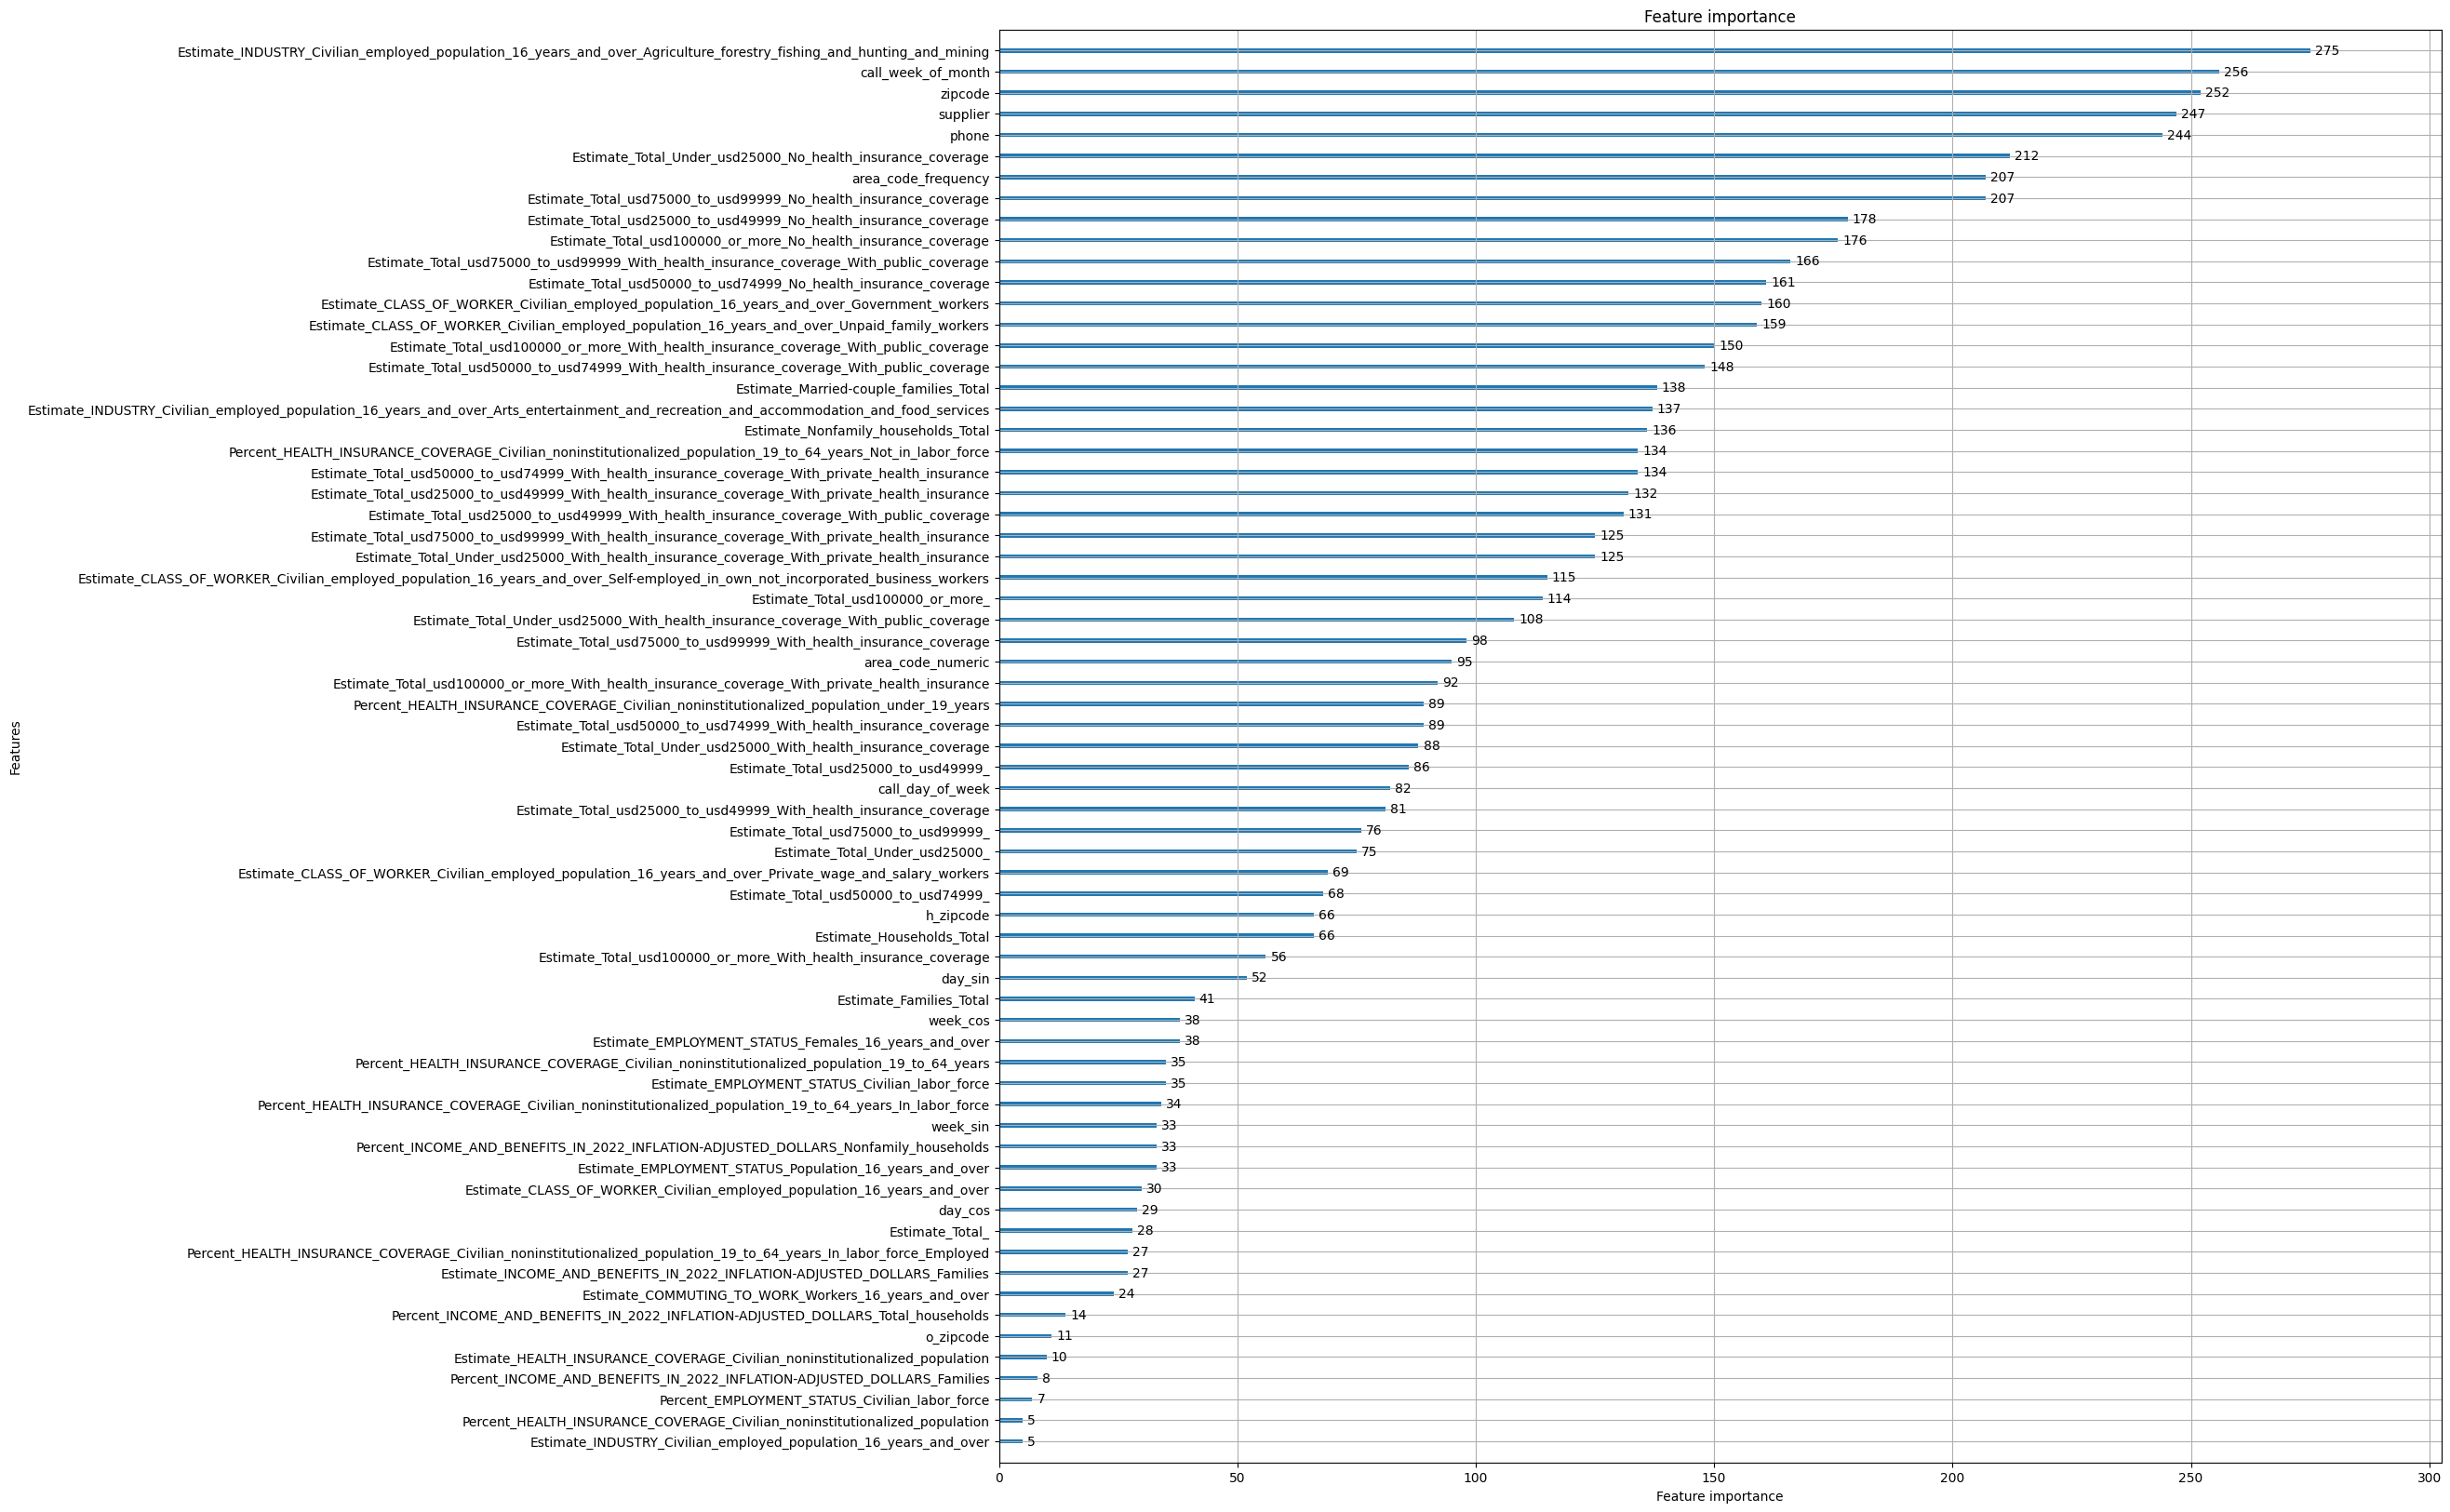

19:46:56.747 | INFO    | Task run 'train_model_with_best_params-72e' - Finished in state Completed()

19:46:57.323 | INFO    | Task run 'visualize_model_performance-1d7' - Finished in state Completed()

19:46:57.628 | INFO    | Flow run 'mottled-meerkat' - Finished in state Completed()


Model Training Complete!
Model Performance Metrics:
accuracy: 0.8391608391608392
roc_auc: 0.6610048847811086
avg_precision: 0.24739874328325454
precision_pos: 0.2983606557377049
recall_pos: 0.21212121212121213
f1_pos: 0.24795640326975477


<Figure size 640x480 with 0 Axes>

In [41]:
@flow(task_runner=ConcurrentTaskRunner)
def lead_sales_mlops_workflow(file_path):
    """
    Main workflow for Lead Sales MLOps project

    Args:
        file_path (str): Path to the input dataset
    """
    # Load data
    raw_data = load_data(file_path)

    # Preprocess data
    cleaned_data = preprocess_data(raw_data)

    # Engineer features
    engineered_data = engineer_features(cleaned_data)

    # Split and prepare data
    X_train, X_test, y_train, y_test = split_and_prepare_data(engineered_data)

    # Train model and get results
    model, predictions, pred_classes, metrics = train_model_with_best_params(
        X_train, X_test, y_train, y_test
    )

    # Visualize model performance
    visualize_model_performance(y_test, predictions, pred_classes)

    return model, metrics

def main():
    """
    Entry point for the Lead Sales MLOps workflow
    """
    file_path = '/content/ml_task_data.csv'
    model, metrics = lead_sales_mlops_workflow(file_path)
    print("\nModel Training Complete!")
    print("Model Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")

if __name__ == "__main__":
    main()

# Future steps:



1.   Addresses the class imbalance issue: using SMOTE technique to create synthetic samples of the minority class to increase its representation.

2.   Data shifts over time: monitor model performance using relevant metrics and set up alerts for significant performance drops. This could trigger the retraining process. Can be done with:
* Kolmogorov-Smirnov test to compare feature distributions
* Population Stability Index (PSI) for categorical and numerical features
* Jensen-Shannon divergence to measure distribution changes


3. Scalability:
* Containerization with Kubernetes
* Distributed model serving (using Spark and Dask for example)
* Cloud-Native Solutions: SageMaker, AzureML

4. Unitary and integration tests
5. Best practices using Docker, code linting, CI/CD and Terraform








# Thanks!
It was a pleasure to do this task. I'm excited for futures tasks that I can develop with you guys.
See you!